# PostScriptML: EDA Notebook
## by Dolci Key 

## Import Libraries

In [22]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#import shap

import glob
import os

from keras import models, layers
from keras.models import Model
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.python.keras.applications import inception_v3, mobilenet_v2, vgg19, densenet
from tensorflow.python.keras.layers import Dense,GlobalAveragePooling2D
import tensorflow as tf
from PIL import Image, ImageOps, ImageFilter

import os, shutil
import argparse
import sys

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics.pairwise import cosine_similarity

import pickle

In [59]:
plt.style.use('fivethirtyeight')
sns.set_palette(sns.diverging_palette(250,700, s= 70 , l= 10, n= 8))

# Data 

For this project, these are my own photos taken with a Nikon Z7. Originally, images were in RAW form (.NEF), however due to memory, compression was necessary for modeling at this time. Photos have been labeled as select and reject just as they would during a photographer's work flow during the selection process. All photographs have run through a batch compressor (Nikon Capture NX-D) to resize 500 x 333 pixels, this was done due to hardware and time constraints. 

### Loading Test, Train, and Validation sets (local use), working off a hard drive. 

In [24]:
# Train
train_reject = '/Volumes/DOLCI KEY 2019/Neural Network/compressed/train_reject_comp'
train_select = '/Volumes/DOLCI KEY 2019/Neural Network/compressed/train_select_comp'

# Test
test_reject = '/Volumes/DOLCI KEY 2019/Neural Network/compressed/test_reject_comp'
test_select = '/Volumes/DOLCI KEY 2019/Neural Network/compressed/test_select_comp'

# Validation 

val_reject = '/Volumes/DOLCI KEY 2019/Neural Network/compressed/validation_reject_comp'
val_select = '/Volumes/DOLCI KEY 2019/Neural Network/compressed/validation_select_comp'

# All Images

reject_images = '/Volumes/DOLCI KEY 2019/Neural Network/compressed/all_reject'
select_images = '/Volumes/DOLCI KEY 2019/Neural Network/compressed/all_select'

In [64]:
# Random Image Generator 

i = 1 
select = [fn for fn in os.listdir(f'{train_select}')]
choose_select= np.random.choice(select, i, replace = False)

In [65]:
choose_select

array(['DKP_2069_00017.jpg'], dtype='<U18')

# Class Imbalance

Due to the nature of marketing, e-commerce, and other fields of photography, many of the images may not be selected for the final usage. This is why class imbalance is generally an issue when it comes to this type of image data. 


In [50]:
# Plot Class Imbalance
data = pd.read_csv('DATA/image_breakdown.csv')
data.head()

,model,race,select,reject,Unnamed: 4,test_select,test_reject,train_select,train_reject,validation_select,validation_reject
0,Samayah,Bi-Racial,105.0,538.0,643.0,0.0,0.0,105.0,538.0,0.0,0.0
1,Bethany,African American,116.0,1065.0,1181.0,0.0,0.0,116.0,1065.0,0.0,0.0
2,Kristen,Caucasian,213.0,476.0,689.0,0.0,0.0,24.0,149.0,189.0,327.0
3,Joanna,Asian,125.0,644.0,769.0,125.0,644.0,0.0,0.0,0.0,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


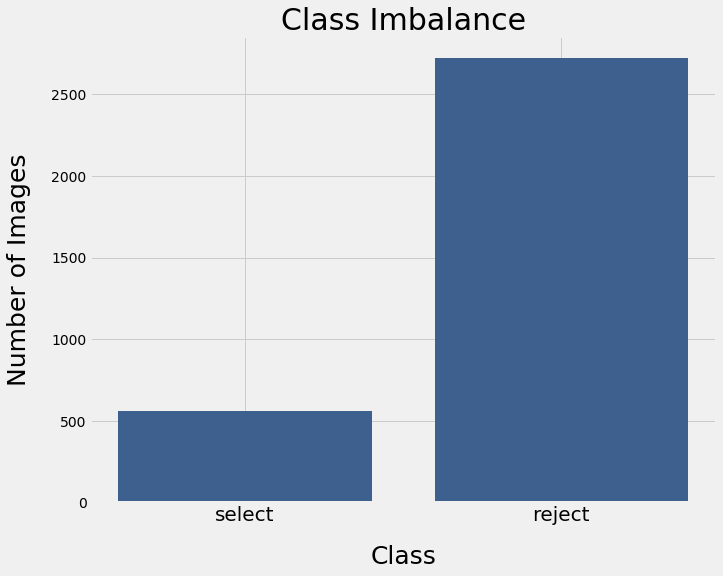

In [138]:
plt.style.use('fivethirtyeight')
sns.set_palette(sns.diverging_palette(250,700, s= 65 , l= 40, n= 1))

fig = plt.figure(figsize = (10, 8))
plt.bar(['select', 'reject'], [data.select.sum(), data.reject.sum()])
plt.title('Class Imbalance', fontsize = 30)
plt.xlabel('Class', fontsize = 25, labelpad = 20)
plt.ylabel('Number of Images', fontsize = 25, labelpad = 20)
plt.xticks(fontsize = 20)
plt.show()

fig.savefig('VISUALS/class_imbalance.png', bbox_inches= 'tight', padding_inches = 4, transparent = True);

In [139]:
data['augmented_images'] = (data.select)*2

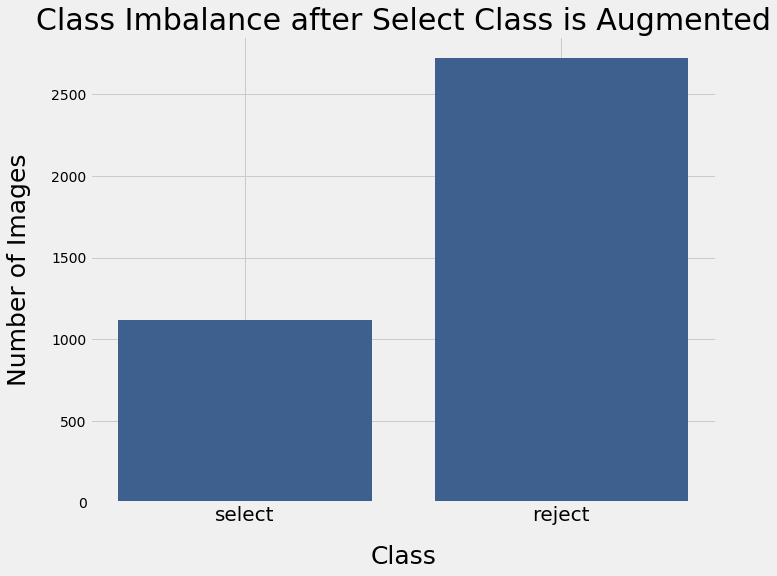

In [140]:
plt.style.use('fivethirtyeight')
sns.set_palette(sns.diverging_palette(250,700, s= 65 , l= 40, n= 1))

fig = plt.figure(figsize = (10, 8))
plt.bar(['select', 'reject'], [data.augmented_images.sum(), data.reject.sum()])
plt.title('Class Imbalance after Select Class is Augmented', fontsize = 30)
plt.xlabel('Class', fontsize = 25, labelpad = 20)
plt.ylabel('Number of Images', fontsize = 25, labelpad = 20)
plt.xticks(fontsize = 20)
plt.show()

fig.savefig('VISUALS/class_imbalance_aug.png', bbox_inches= 'tight', padding_inches = 4, transparent = True);

# Racial Breakdown of Images

As I am aware CNN can preform poorly if enough diverse data is not given for training, particularly when it comes to race, I have tried very hard to add representation of many races across many skin tones to the data set. Here we see we have more African American representation in the data overall. 

However, when that comes to reject and select, that data looks a little different. 
--this likely is due to the fact that the Caucasian and Bi-Racial models used in this data were more experienced in posing, and also the time of day, as more images are likely to be rejected when the sun is bright and the model may have closed her eyes or has a less optimal expression on her face as a result of the bright sunlight.


In [58]:
data['total_images'] = (data.select) + (data.reject)

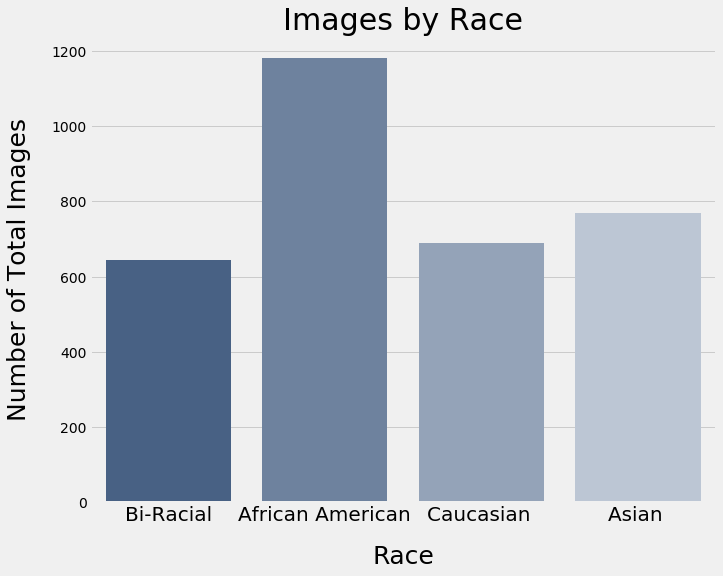

In [133]:
plt.style.use('fivethirtyeight')
sns.set_palette(sns.diverging_palette(250,700, s= 65 , l= 40, n= 10))

fig = plt.figure(figsize = (10, 8))
sns.barplot(x = 'race', y = 'total_images', data = data, ci = None)
plt.title('Images by Race', fontsize = 30)
plt.xlabel('Race', fontsize = 25, labelpad = 20)
plt.ylabel('Number of Total Images', fontsize = 25, labelpad = 20)
plt.xticks(fontsize = 20)
plt.show()

fig.savefig('VISUALS/data_by_race.png', bbox_inches= 'tight', padding_inches = 4, transparent = True);

In [ ]:
data.dropna(inplace = True)

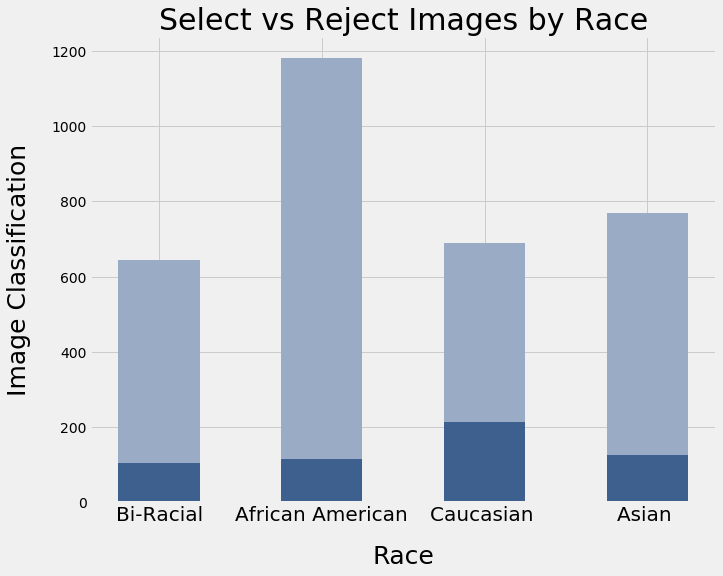

In [141]:
plt.style.use('fivethirtyeight')
sns.set_palette(sns.diverging_palette(250,700, s= 65 , l= 40, n= 5))


fig = plt.figure(figsize = (10, 8))

race = list(data.race)
num_select = list(data.select)
num_reject = list(data.reject)

plt.bar(race, num_select, width = .5)
plt.bar(race, num_reject, width =.5,bottom = num_select)

plt.title('Select vs Reject Images by Race', fontsize = 30)
plt.xlabel('Race', fontsize = 25, labelpad = 20)
plt.ylabel('Image Classification', fontsize = 25, labelpad = 20)
plt.xticks(fontsize = 20)

plt.show()

fig.savefig('VISUALS/select_reject_race.png', bbox_inches= 'tight', padding_inches = 4, transparent = True);